# Predicting daily returns using a correlated signal

In this notebook, we will generate two highly correlated uniform time series and apply linear regression on one to predict daily returns on the other.

In [1]:
import datetime
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Generate a range of dates

We'll start with 7 years of business days as our index.

In [3]:
start_date = datetime.date(2010, 1, 1)
end_date = datetime.date(2017, 12, 31)
dates = pd.bdate_range(start_date, end_date)
dates

DatetimeIndex(['2010-01-01', '2010-01-04', '2010-01-05', '2010-01-06',
               '2010-01-07', '2010-01-08', '2010-01-11', '2010-01-12',
               '2010-01-13', '2010-01-14',
               ...
               '2017-12-18', '2017-12-19', '2017-12-20', '2017-12-21',
               '2017-12-22', '2017-12-25', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', length=2086, freq='B')

## Generate correlated normal variables with mu=0, sigma=1bps

We choose covariance so that the resulting correlation is slightly more than 0.5.

In [4]:
mu = 0
standard_deviation = 1e-4
covariance = 5.5e-5
assert standard_deviation > covariance

cov = [[standard_deviation, covariance], [covariance, standard_deviation]]
x, y = np.random.multivariate_normal([mu, mu], cov, dates.size).T
signals = pd.Series(index=dates, data=x)
returns = pd.Series(index=dates, data=y)

signals.std(), returns.std(), signals.corr(returns)

(0.010108185511279646, 0.009697821783521457, 0.526902341703893)

## Generate a price chart

We randomly choose a starting price between \\$5 and \\$10, to give a flavor of what the stock price action might be. The unit of the signal is not meant to be dollars, but we multiply it by the same number so we can easily compare the time series.

0.628767105481876

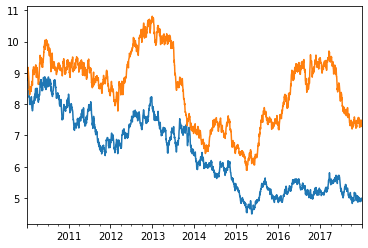

In [5]:
starting_price = np.random.randint(5, 10)
sentiments = starting_price * (1+signals[1:]).cumprod()
prices = starting_price * (1+returns[1:]).cumprod()

ax = sentiments.plot()
ax = prices.plot()
prices.corr(sentiments)

Note the correlation is independent of the random starting price, and is different from the correlation of the returns.

## Using one time-series as a signal for the other

Think of the signal as something like news sentiment. If sentiment is higher today, you'd expect the stock returns to also increase.

`predicted_returns(t) ~ sentiment_diff(t)`

Now we must go back to the returns space.

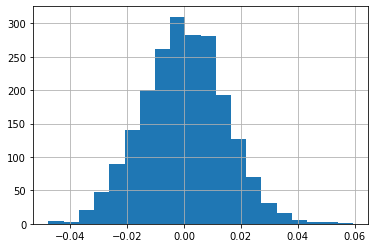

In [6]:
signals_ready = signals.diff().dropna()
returns_ready = returns.loc[signals_ready.index[0]:signals_ready.index[-1]]

assert returns_ready.size == signals_ready.size

ax = signals_ready.hist(bins=20)

## Plotting returns

In [7]:
df = pd.concat([signals_ready, returns_ready], axis=1, keys=["X", "y"])
df

,X,y
2010-01-04,-0.002903,-0.007477
2010-01-05,-0.003976,-0.000884
2010-01-06,0.001943,-0.007336
2010-01-07,0.002745,0.000640
2010-01-08,-0.007560,0.010725
...,...,...
2017-12-25,0.019407,0.003877
2017-12-26,-0.012292,-0.008951
2017-12-27,-0.001690,-0.016716
2017-12-28,0.024777,-0.001603


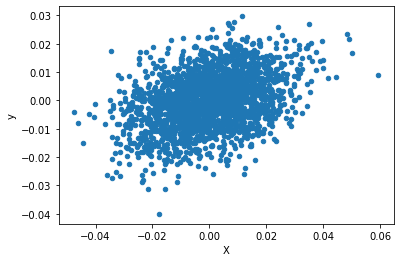

In [8]:
ax = df.plot(kind="scatter", x="X", y="y")

As expected, we observe a strong linear relationship.

## Plotting prices

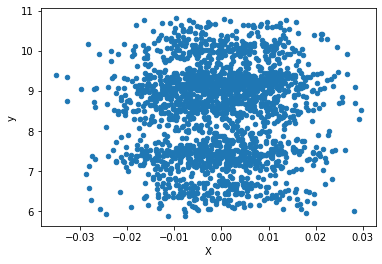

In [9]:
prices_ready = prices.loc[signals.index[0]:signals.index[-1]]
ax = pd.concat([signals, prices_ready], axis=1, keys=["X", "y"]).plot(kind="scatter", x="X", y="y")

Also as expected, we observe no relationship for prices.

## Linear Regression

We run linear regression as follows:

`predicted_returns(t) = slope * sentiment_diff(t) + intercept`

Our baseline model will be `(slope = 1, intercept = 0)`, i.e. the input feature is passed through unchanged as the prediction.

In [10]:
train_size = 0.8
dates_test = dates[-int((1-train_size)*dates.size):]

X = df.X.values.reshape(-1, 1)
y = df.y.values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=False)
X_train[:5]

array([[-0.00290295],
       [-0.00397605],
       [ 0.0019428 ],
       [ 0.00274471],
       [-0.00755978]])

In [11]:
reg = LinearRegression().fit(X_train, y_train)
reg.coef_, reg.intercept_

(array([[0.2302651]]), array([5.68081586e-05]))

In [12]:
baseline = r2_score(y_test, X_test)
score = reg.score(X_test, y_test)

assert score > 0
assert score > baseline
score

0.1458092462719559

The R2 score is positive, and our fitted model performs better than the baseline.

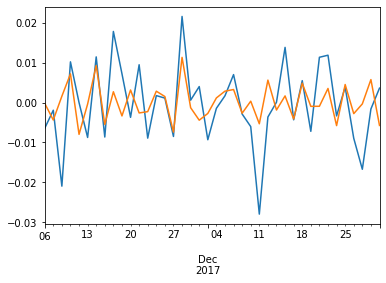

In [13]:
predictions = pd.Series(index=dates_test, data=reg.predict(X_test).flatten())
days = 40
ax = df.y.loc[dates_test].tail(days).plot()
ax = predictions.tail(days).plot()

The magnitude is off, but the direction is accurate.

## Calculate PnL

We'll assume 1:1 returns with a 100% exposure, using only the sign of the prediction.

In [14]:
strategy = pd.concat([pd.Series(X_test.flatten()), pd.Series(y_test.flatten()), pd.Series(reg.predict(X_test).flatten())], axis=1, keys=["x", "y", "y_pred"])
strategy.index = dates[-strategy.shape[0]:]
strategy["found_direction"] = np.sign(strategy.y) * np.sign(strategy.y_pred)
strategy["pnl"] = strategy.y * np.sign(strategy.y_pred)
strategy["cum_pnl"] = (1+strategy.pnl).cumprod()

strategy

,x,y,y_pred,found_direction,pnl,cum_pnl
2016-05-26,-0.008812,-0.016190,-0.001972,1.0,0.016190,1.016190
2016-05-27,-0.007771,-0.004726,-0.001733,1.0,0.004726,1.020993
2016-05-30,0.015839,0.006812,0.003704,1.0,0.006812,1.027948
2016-05-31,-0.007222,0.013567,-0.001606,-1.0,-0.013567,1.014002
2016-06-01,0.011292,-0.006471,0.002657,-1.0,-0.006471,1.007441
...,...,...,...,...,...,...
2017-12-25,0.019407,0.003877,0.004526,1.0,0.003877,3.194880
2017-12-26,-0.012292,-0.008951,-0.002774,1.0,0.008951,3.223476
2017-12-27,-0.001690,-0.016716,-0.000332,1.0,0.016716,3.277360
2017-12-28,0.024777,-0.001603,0.005762,-1.0,-0.001603,3.272107


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


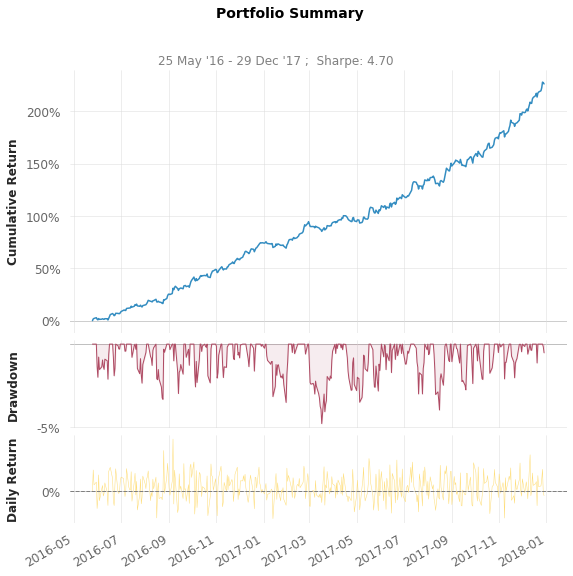

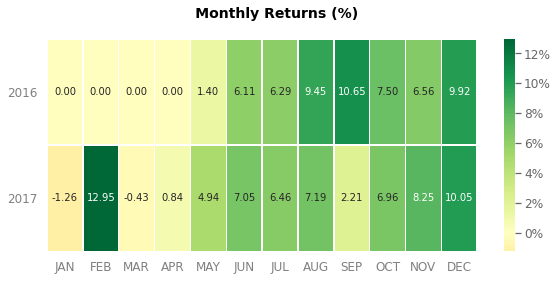

In [15]:
import quantstats as qs
qs.reports.plots(strategy.pnl)

How are daily returns distributed?

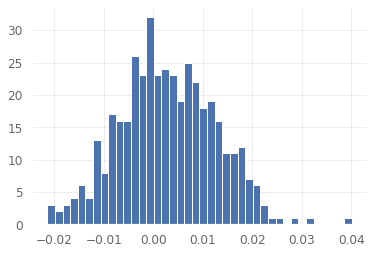

In [16]:
ax = strategy.pnl.hist(bins=40)

What percentage of the time do we correctly predict the return direction?

 1.0    0.589928
-1.0    0.410072
Name: found_direction, dtype: float64

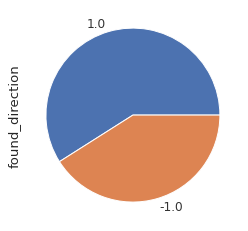

In [17]:
ax = strategy.found_direction.value_counts().plot.pie()
strategy.found_direction.value_counts(normalize=True)

## Conclusion

The results are outstanding, but finding a signal with such a **high** correlation to the asset and that is available **before** the returns happen is non-trivial.